# PREOPS-598-diffim-sprint-recproc

## Diagnostic plots of the 2021 diffimg sprint datasets reprocess with w_31 and having the recommended setting for each iteration

In [1]:

import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import importlib
import pandas as pd

from astropy.coordinates import SkyCoord
import astropy.units as u
from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)

import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
afwDisplay.setDefaultBackend('matplotlib')
import lsst.daf.butler as dafButler
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct

import IPython
from IPython.display import IFrame

In [2]:
#sys.path.append('/project/mrawls/ap_pipe-notebooks/')
sys.path.append('/project/kherner/PREOPS-598_reprocSprint/ap_pipe-notebooks/')

In [3]:
import diaObjectAnalysis as doa
import apdbPlots as pla
import plotLightcurve as plc
import coaddAnalysis as coa

In [4]:
repo = '/datasets/hsc/gen3repo/rc2w50_ssw02'
butler = dafButler.Butler(repo)

In [5]:
default_best = SimpleNamespace(collection = 'u/kherner/PREOPS-598_w31_default_bestSeeing_20210806',
                               apdb = 'lsstdevapdb1',
                              schema = 'kherner_PREOPS_598_default_best')
preconvolve_best = SimpleNamespace(collection = 'u/kherner/PREOPS-598_w31_default_bestSeeing_Preconvolve_20210806',
                                            apdb = 'lsstdevapdb1',
                                  schema = 'kherner_PREOPS_598_PreConvolve')
default_middle = SimpleNamespace(collection = 'u/kherner/PREOPS-598_w31_default_middleSeeing_20210806',
                                 apdb = 'lsstdevapdb1',
                                schema = 'kherner_PREOPS_598_default_middle')
convolvesci_middle = SimpleNamespace(collection = 'u/kherner/PREOPS-598_w31_default_middleSeeing_convolveSci',
                                     apdb = 'lsstdevapdb1',
                                    schema = 'kherner_PREOPS_598_convolveSci' )


In [6]:

apdbs_nonempty = [default_best, preconvolve_best, default_middle, convolvesci_middle]

badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

print(f'N DiaSources and N "good" DiaSources in each collection')
print(f'-------------------------------------------------------')
for run in apdbs_nonempty:
    collection = run.collection
    apdb = run.apdb
    schema = run.schema
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=apdb,
                                                          gen='gen3',
                                                          schema=schema,
                                                          instrument='HSC',
                                                          badFlagList=badFlagList)
    print(f'{len(srcTable):7d}\t{len(goodSrc):7d}\t\t{collection.split("/")[-1]}')

N DiaSources and N "good" DiaSources in each collection
-------------------------------------------------------
 111818	  35215		PREOPS-598_w31_default_bestSeeing_20210806
 135847	  50633		PREOPS-598_w31_default_bestSeeing_Preconvolve_20210806
  97495	  30040		PREOPS-598_w31_default_middleSeeing_20210806
 164824	  88221		PREOPS-598_w31_default_middleSeeing_convolveSci


diffim variance median
----------------------
485.868561	PREOPS-598_w31_default_bestSeeing_20210806
448.797119	PREOPS-598_w31_default_bestSeeing_Preconvolve_20210806
717.634888	PREOPS-598_w31_default_middleSeeing_20210806
640.157715	PREOPS-598_w31_default_middleSeeing_convolveSci


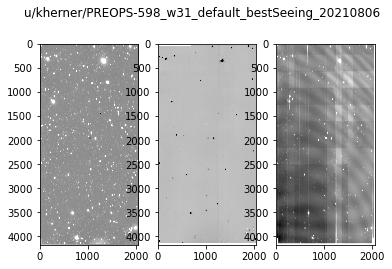

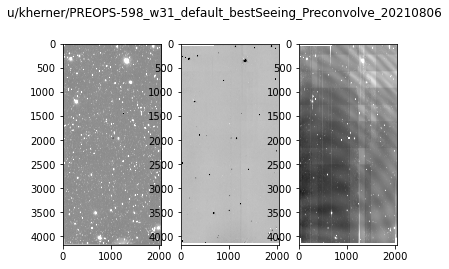

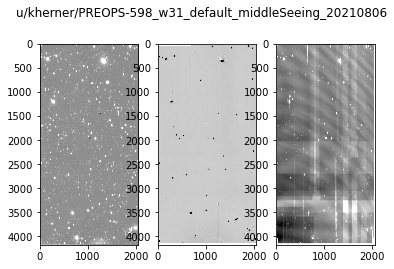

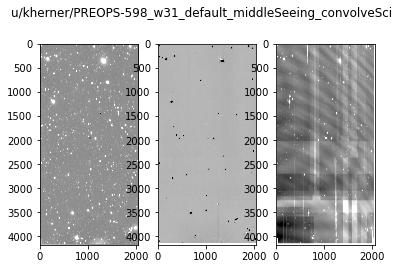

In [7]:

oneVisit = 1220
oneDetector = 66

collection_list = [default_best.collection,
                   preconvolve_best.collection,
                   default_middle.collection,
                   convolvesci_middle.collection]
print(f'diffim variance median')
print(f'----------------------')
for collections in collection_list:
#for collections in [default_best.collection, preconvolve_best.collection]:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)
    diffim = butler.get('deepDiff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)

    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{collections.split("/")[-1]}')

## Make key plots for all the runs


Here, I'll construct `run_list` to showcase ones with best-seeing templates by default, and showcase ones with worst-seeing templates in the case differencing was run with preconvolution **or** science image convolution (instead of template convolution).

In [8]:
def makeplots(run):
    collection = run.collection
    apdb = run.apdb
    schema=run.schema
    print(collection, apdb)
    dbPath = apdb
    objTable, srcTable, goodObj, goodSrc = pla.loadTables(repo,
                                                          dbType='postgres',
                                                          dbName=dbPath,
                                                          schema=schema,
                                                          gen='gen3',
                                                          instrument='HSC')
    srcTable = pla.addVisitCcdToSrcTable(srcTable, instrument='HSC', gen='gen3', butler=butler)
    flagTable, srcTableFlags, flagFilter, goodSrc, goodObj = pla.makeSrcTableFlags(srcTable, objTable,
                                                                                   badFlagList=badFlagList,
                                                                                   gen='gen3', instrument='HSC',
                                                                                   repo=repo)
    # Good DIA Sources
    fig = plt.figure(figsize=(4,4))
    xlim = (150.45, 149.8)
    ylim = (2.1, 2.5)
    ax = fig.add_subplot(111)
    plt.setp(ax, xlim=xlim, ylim=ylim)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.scatter(goodSrc['ra'], goodSrc['decl'], c='C0', s=0.1, marker='o', alpha=0.4)
    ax.set_xlabel('RA (deg)')
    ax.set_ylabel('Dec (deg)')
    ax.set_title(f'DIA Sources ({str(collection).split("/")[-1]})')
    
    # Good DIA Sources by visit
    bandList = ['g', 'r']
    colorList = ['C2', 'C1']
    for band, color in zip(bandList, colorList):
        pla.plotDiaSourcesOnSkyGrid(repo, goodSrc.loc[goodSrc['filterName'] == band],
                                    title=band+' band', color=color, size=5)
    
    # How many DIA Sources comprise each DIA Object
    hist = doa.plotDiaObjectHistogram(objTable, goodObj)
    
    # Flag bar chart
    pla.plotFlagHist(srcTable, badFlagList=badFlagList)
    
    # Flux distributions
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='psFlux',
                        title='DIA Sources, HSC-G, Diffim PSF Flux', color1='C2', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='psFlux',
                        title='DIA Sources, HSC-R, Diffim PSF Flux', color1='C1', binmin=-1e3, binmax=1e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'g'], fluxType='totFlux',
                        title='DIA Sources, HSC-G, Calexp PSF Flux', color1='C2', binmin=-1e3, binmax=2e3)
    pla.plotFluxHistSrc(goodSrc.loc[goodSrc['filterName'] == 'r'], fluxType='totFlux',
                        title='DIA Sources, HSC-R2, Calexp PSF Flux', color1='C1', binmin=-1e3, binmax=2e3)
    
    # Flux histograms
    pla.source_magnitude_histogram(repo, goodSrc, 'g', 'HSC', collection)
    pla.source_magnitude_histogram(repo, goodSrc, 'r', 'HSC', collection)
    
    # A few cutouts
    for index, source in goodSrc[:4].iterrows():
        dataId = {'detector': int(goodSrc['ccd'][index]), 'visit': int(goodSrc['visit'][index]), 'instrument': 'HSC'}
        center = lsst.geom.SpherePoint(goodSrc['ra'][index], goodSrc['decl'][index], lsst.geom.degrees)
        scienceCutout, differenceCutout, templateCutout = plc.retrieveCutouts(butler, dataId, collection, center)
        plc.plotCutout(scienceCutout, differenceCutout, templateCutout)

In [9]:
run_list = [default_best, default_middle, convolvesci_middle, preconvolve_best]

### Plots for defaults, best third seeing templates

u/kherner/PREOPS-598_w31_default_bestSeeing_20210806 lsstdevapdb1


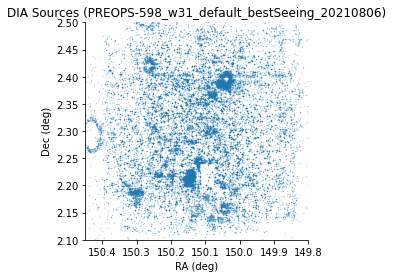

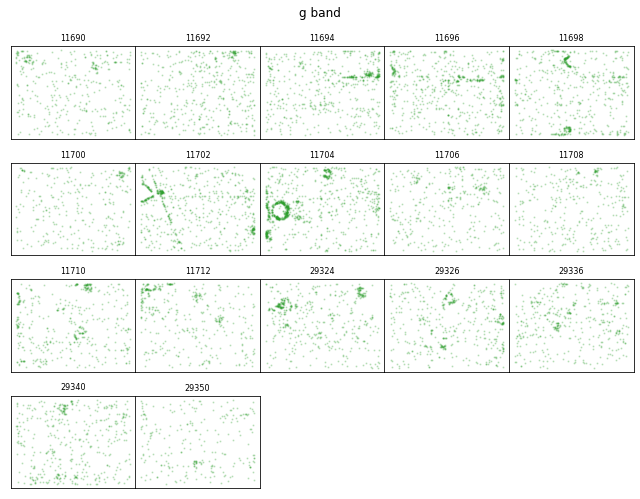

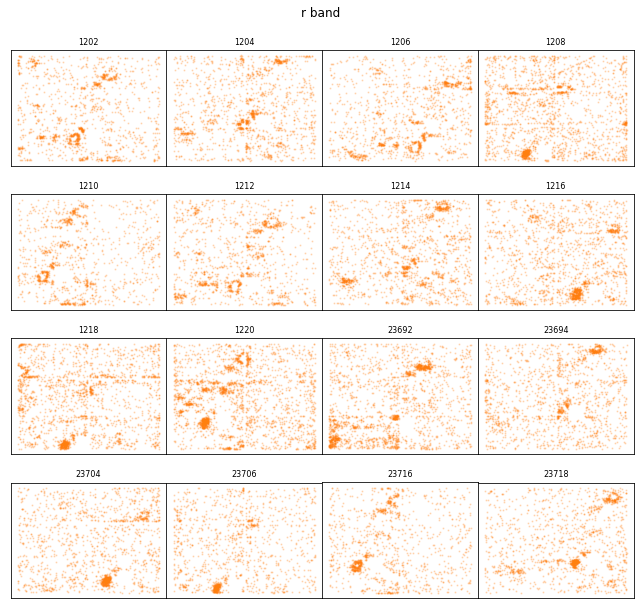

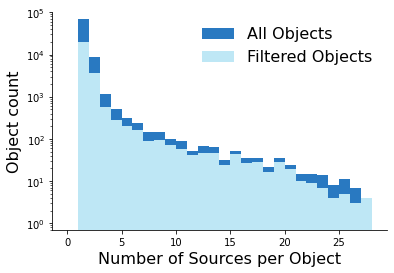

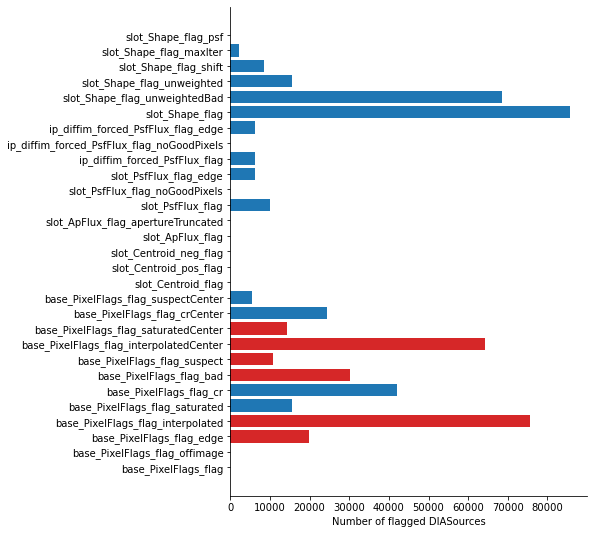

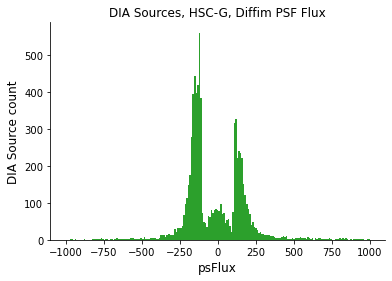

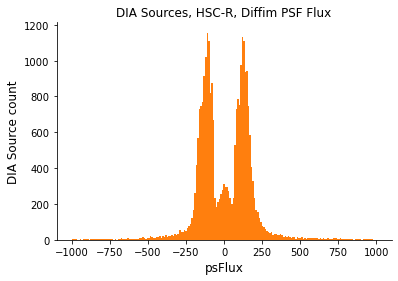

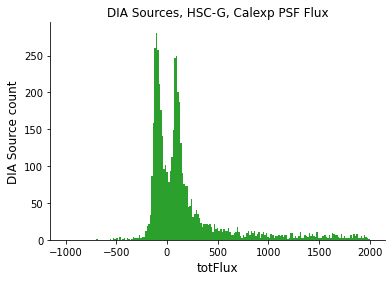

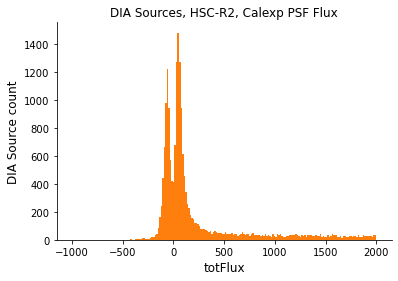

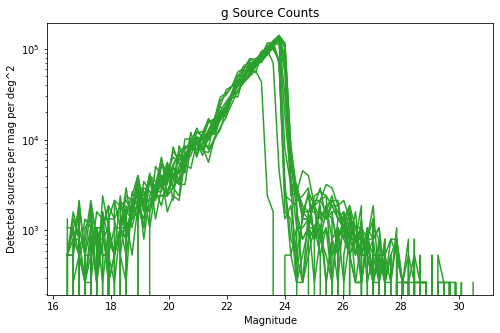

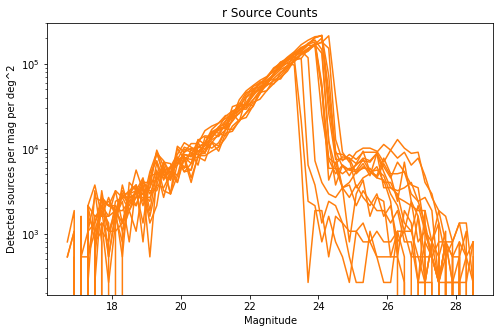

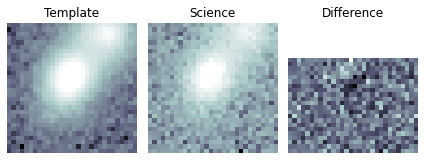

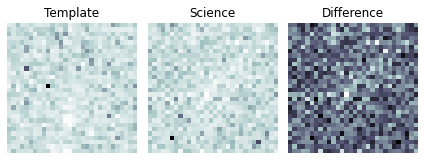

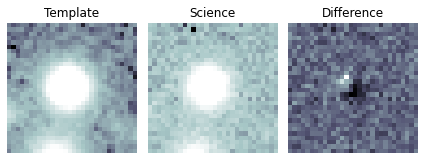

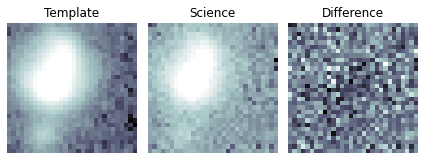

In [10]:
makeplots(default_best)

### Plots for preconvolution, best third seeing templates

u/kherner/PREOPS-598_w31_default_bestSeeing_Preconvolve_20210806 lsstdevapdb1


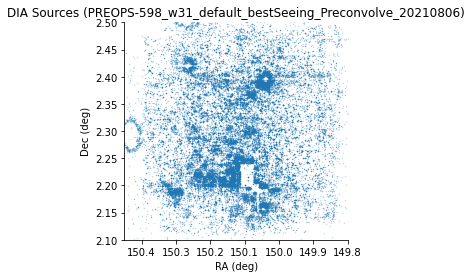

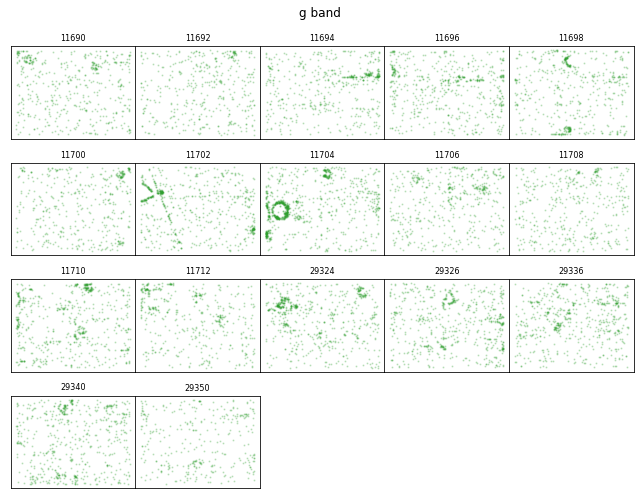

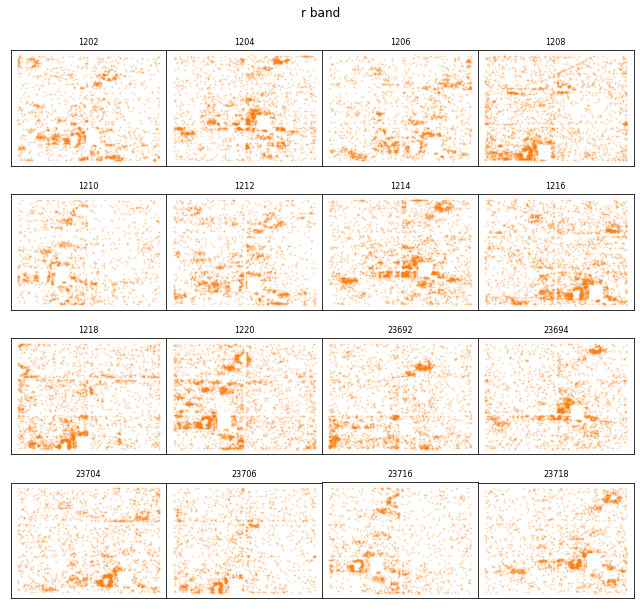

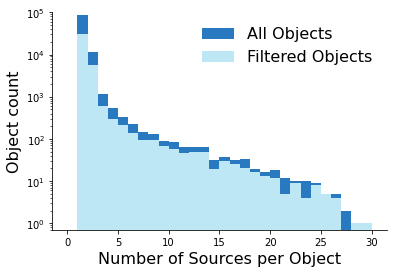

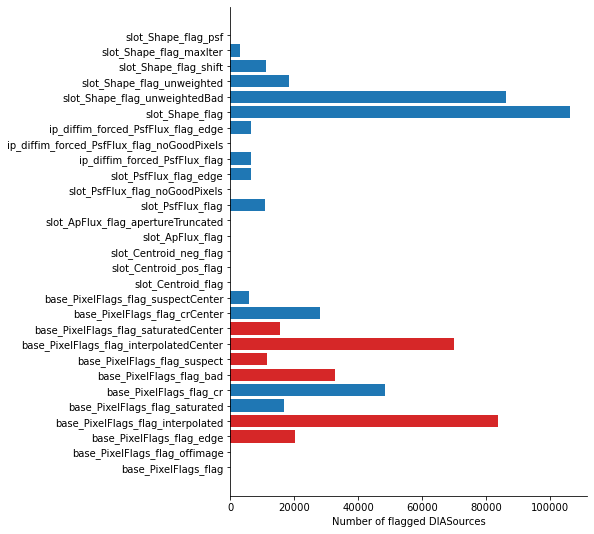

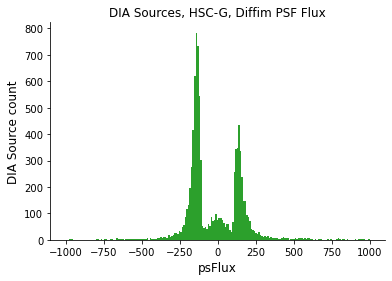

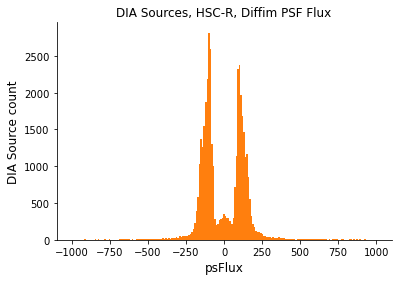

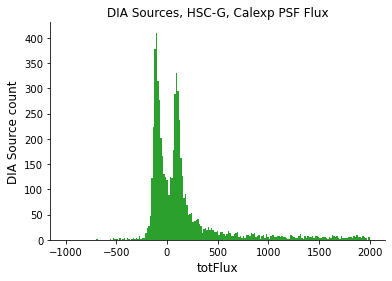

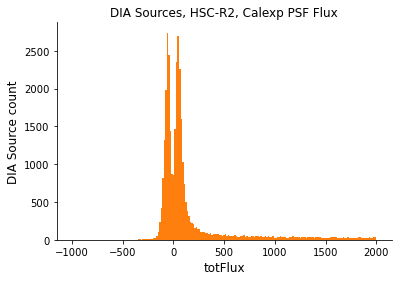

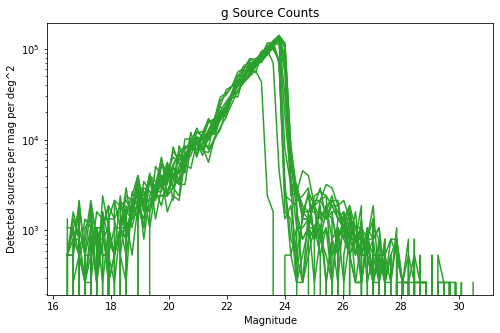

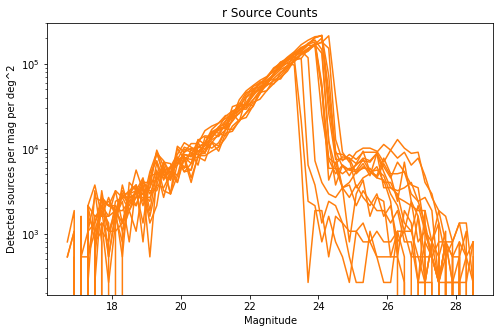

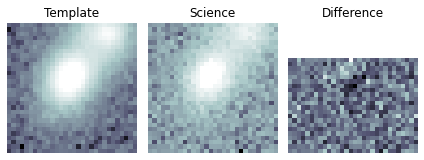

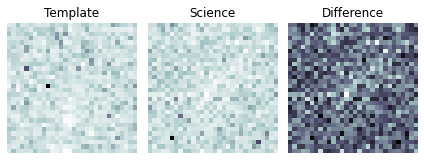

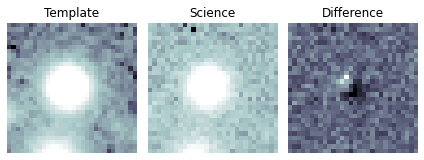

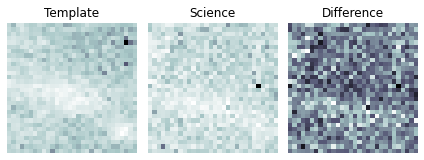

In [11]:
makeplots(preconvolve_best)

### Plots for defaults, middle third seeing templates

u/kherner/PREOPS-598_w31_default_middleSeeing_20210806 lsstdevapdb1


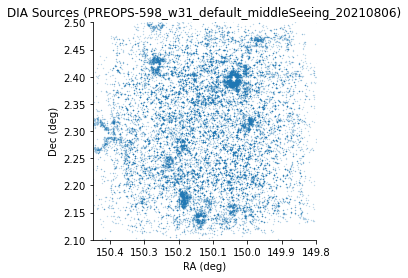

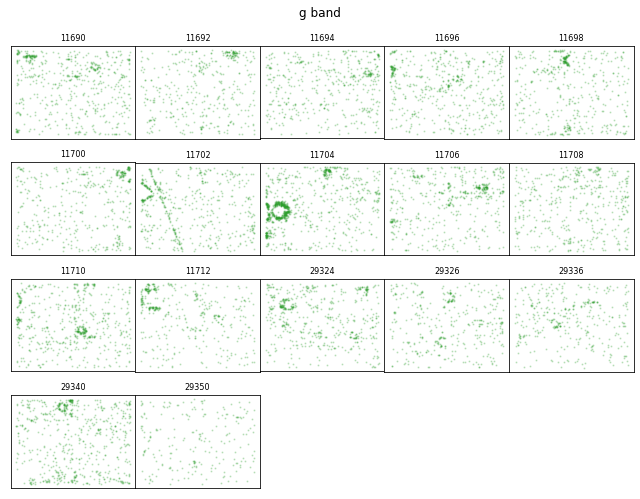

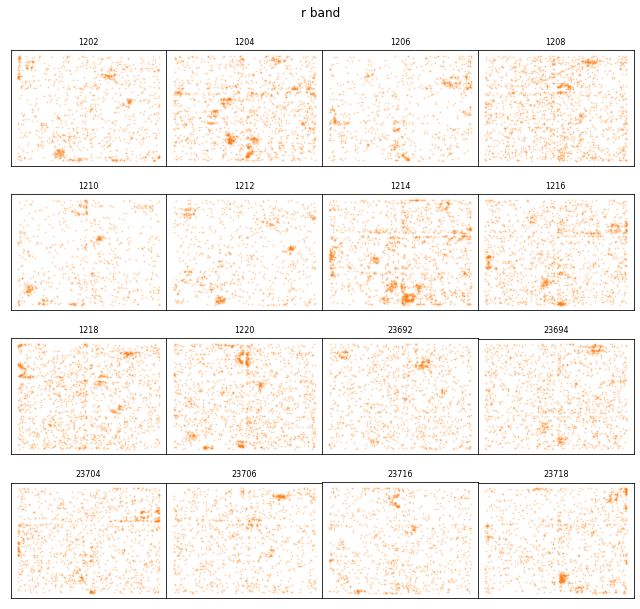

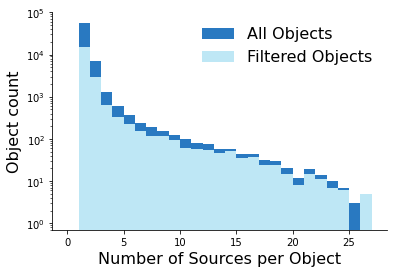

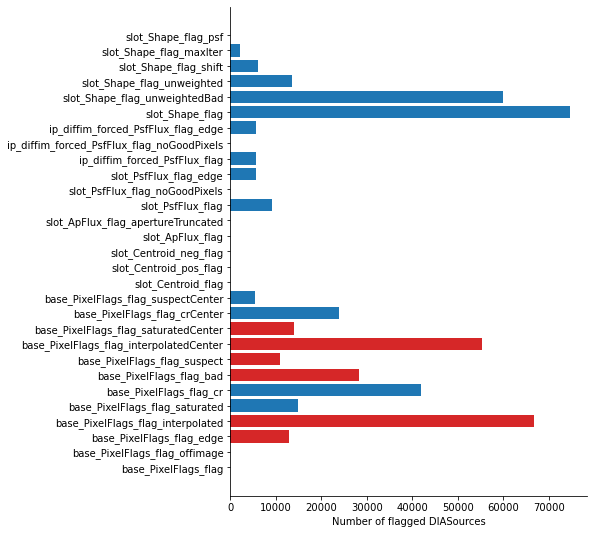

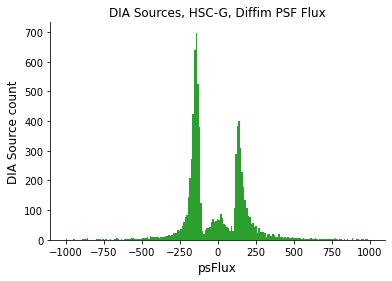

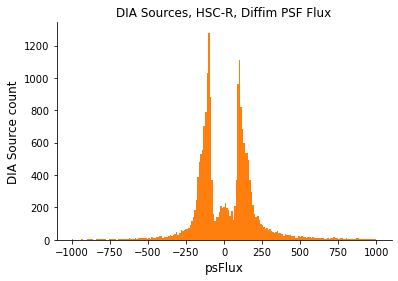

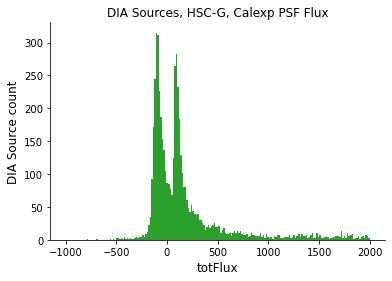

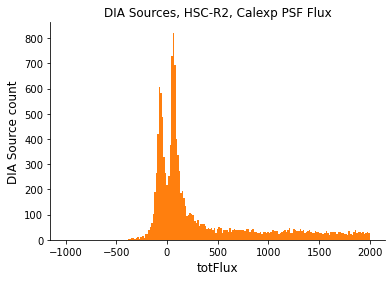

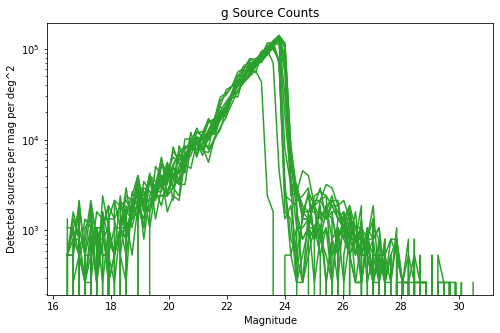

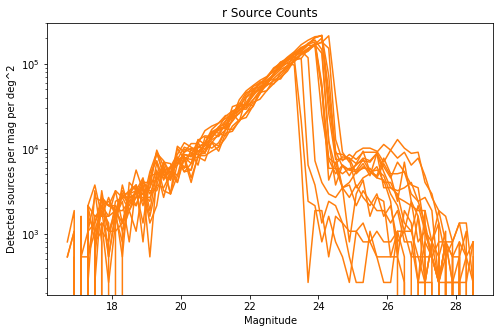

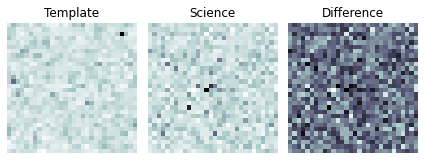

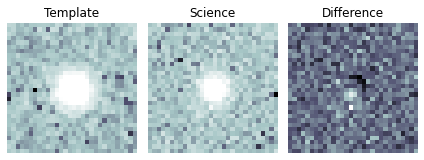

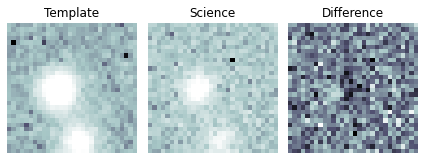

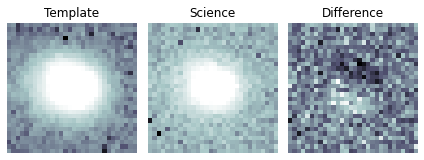

In [12]:
makeplots(default_middle)

### Plots for convolving science image, middle third seeing templates

u/kherner/PREOPS-598_w31_default_middleSeeing_convolveSci lsstdevapdb1


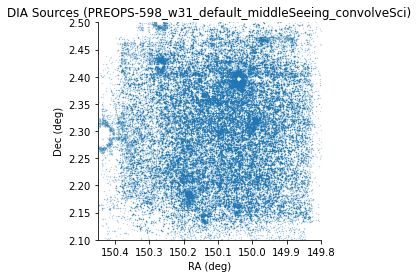

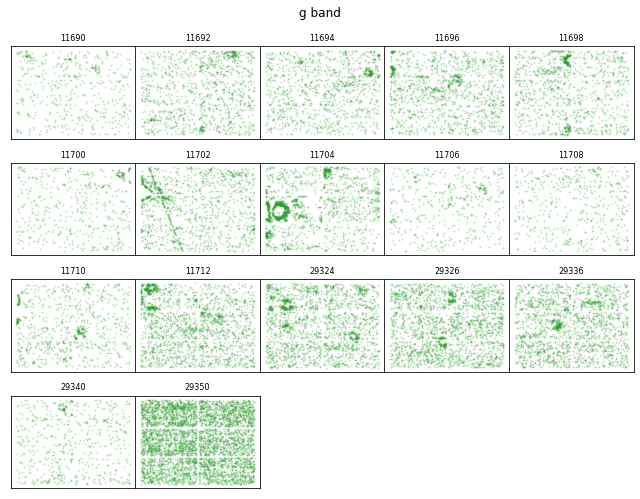

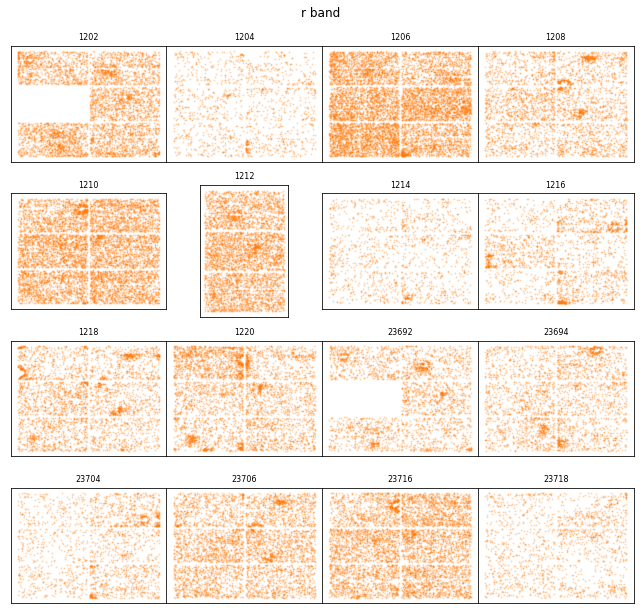

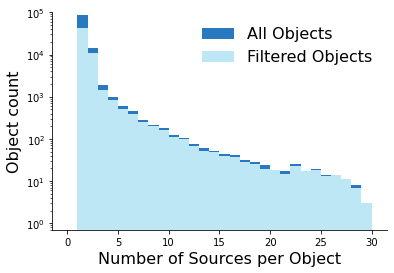

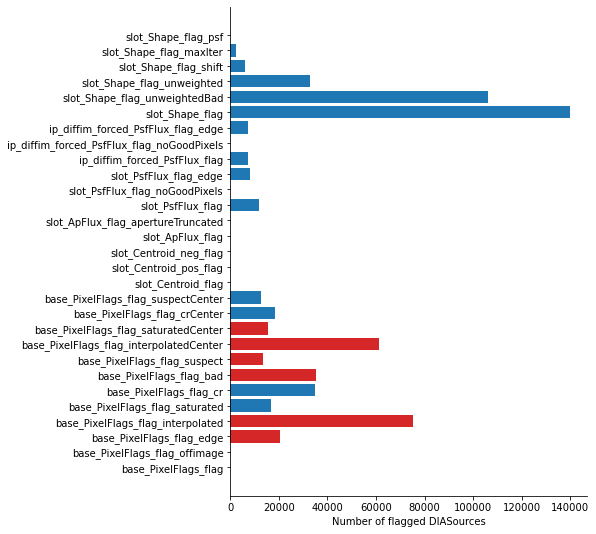

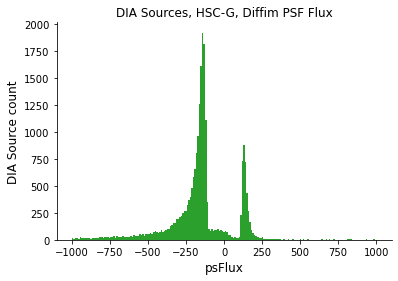

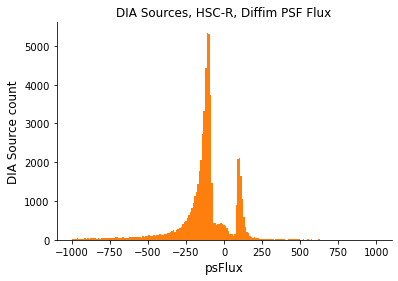

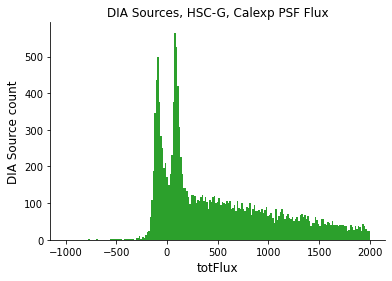

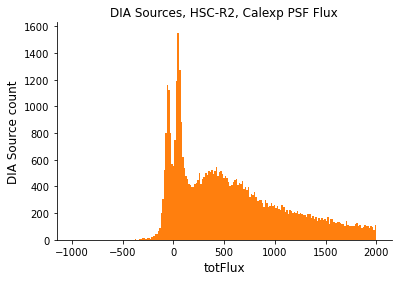

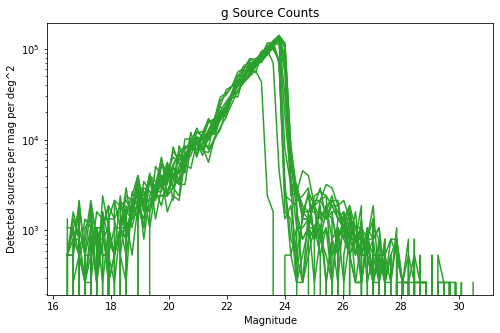

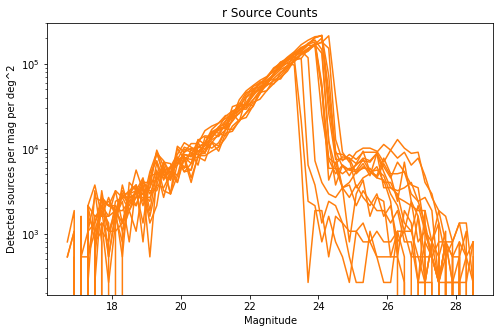

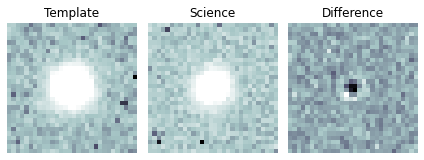

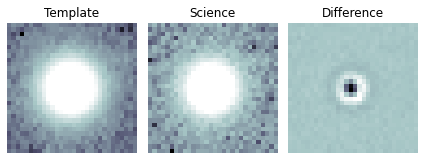

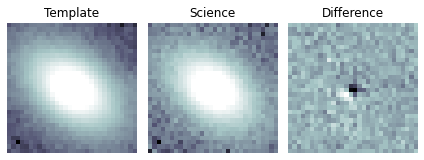

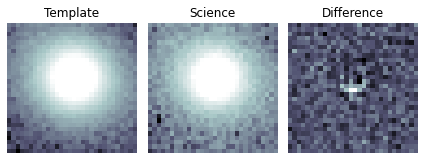

In [13]:
makeplots(convolvesci_middle)